In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.signal as sig
from statsmodels.nonparametric.smoothers_lowess import lowess

In [6]:
basepath = '/arc/home/ksand/Basecat_morph/DM_struct_max/run4/'
entries = os.listdir(basepath)

entries.remove('41365524')  ### This is the event id where we can't see the burst or the burst is too weak ######
entries.remove('42842438') ### This is the event id where we can't see the burst or the burst is too weak ######
entries.remove('42637411') ### This is the event id where we can't see the burst or the burst is too weak ######

entries = np.array(entries)
entries = np.sort(entries)

print(entries.shape)

(137,)


In [30]:
data_basecat = pd.read_json('/arc/home/ksand/Basecat_morph/Basecat_morph.json')
time_res = data_basecat['Time_res(s)'].to_numpy()
dms = data_basecat['DM'].to_numpy()
tns_name = data_basecat['TNS_name'].to_numpy()
low_freq = data_basecat['Bandwidth_low'].to_numpy()
high_freq = data_basecat['Bandwidth_high'].to_numpy()
fit_types = data_basecat['Fit_type'].to_numpy()

In [112]:
path = '/arc/home/ksand/Basecat_morph/fitburst_runs/fitburst_run4/'

for i in range(18,19):

    print("Running event", i, entries[i])
    event_path = os.path.join(path, str(entries[i]))

    spectra_input = event_path + '/model_bandwidth_{}.npz'.format(entries[i])

    data_spec = np.load(spectra_input, allow_pickle = True)


    model_ts = None
    print("Fit type is", fit_types[i])
    if fit_types[i] == 'Scint':
        burst_input = event_path + '/model_scint_{}.npz'.format(entries[i])
        data = np.load(burst_input, allow_pickle = True)
        model_wfall = data['model']
        wfall = data['data']

    if fit_types[i] == 'Scat':
        burst_input = event_path + '/model_scat_{}.npz'.format(entries[i])
        data = np.load(burst_input, allow_pickle = True)
        model_wfall = data['model']
        wfall = data['data']

    if fit_types[i] == 'Noscat':
        burst_input = event_path + '/model_no_scat_{}.npz'.format(entries[i])
        data = np.load(burst_input, allow_pickle = True)
        model_wfall = data['model']
        wfall = data['data']

    if fit_types[i] == 'Profile':
        print("getting the profile")
        burst_input = event_path + '/model_mcmc_profile_{}.npz'.format(entries[i])
        data = np.load(burst_input, allow_pickle = True)
        model_ts = data['model']
        model_wfall = None
        wfall = data['data']

    if fit_types[i] == 'Failed':
        try:
            print("getting the profile")
            burst_input = event_path + '/model_mcmc_profile_{}.npz'.format(entries[i])
            data = np.load(burst_input, allow_pickle = True)
            model_ts = data['model']
            model_wfall = None
            wfall = data['data']
        except:
            burst_input = event_path + '/model_scat_{}.npz'.format(entries[i])
            data = np.load(burst_input, allow_pickle = True)
            model_wfall = data['model']
            wfall = data['data']


    dm = dms[i]
    t_res = time_res[i]
    event = tns_name[i] ##### Replace with TNS name
    lo = low_freq[i]
    hi = high_freq[i]
    t_arr = data['arrival_time']#data['arrival_time']/4 #-> This for event 25281508, 40594289
    model_spec = data_spec['model']

Running event 18 24365582
Fit type is Scint


(1024, 1450)


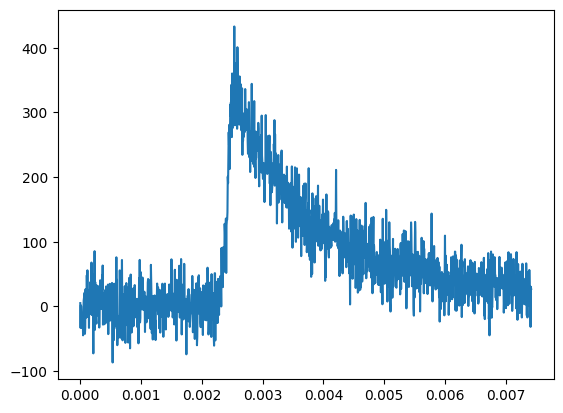

In [113]:
print(wfall.shape)
ts = np.sum(wfall, axis=0)
plot_time = np.arange(0,len(ts),1) * t_res
plt.plot(plot_time, ts)
plt.show()

0.1425213866131287
The rise time in channels 0 to 255 is 640.0 us in frequency range 400.0 - 499.7067448680352 MHz


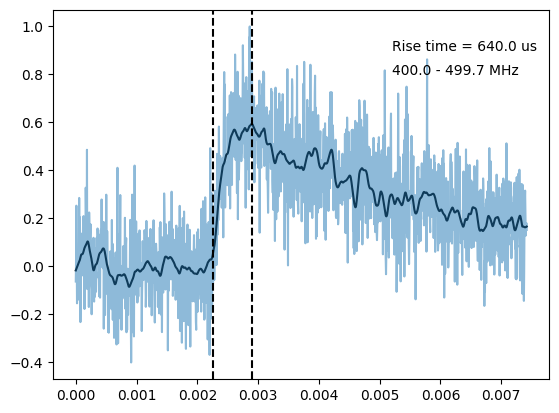

0.10968802644377104
The rise time in channels 256 to 511 is 215.04 us in frequency range 500.09775171065496 - 599.8044965786901 MHz


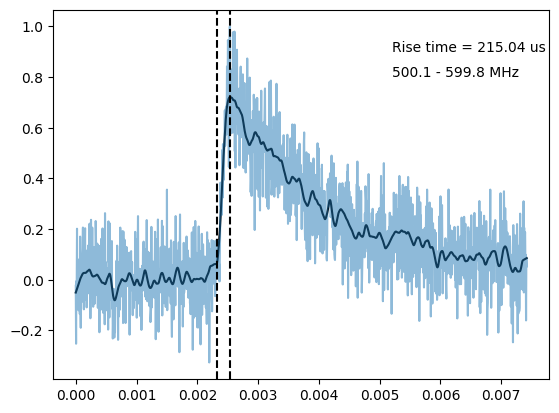

0.08903167209458886
The rise time in channels 512 to 767 is 235.51999999999998 us in frequency range 600.1955034213099 - 699.902248289345 MHz


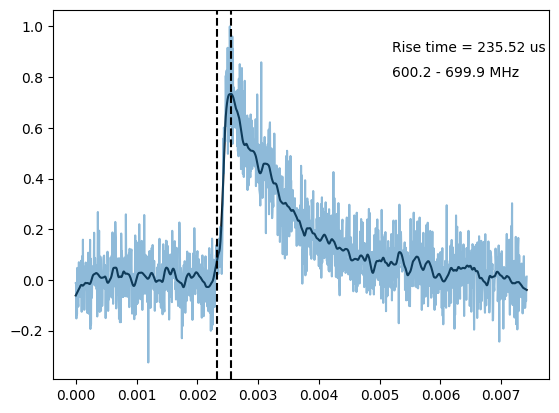

0.12324989954127874
The rise time in channels 768 to 1023 is 215.04 us in frequency range 700.2932551319648 - 800.0 MHz


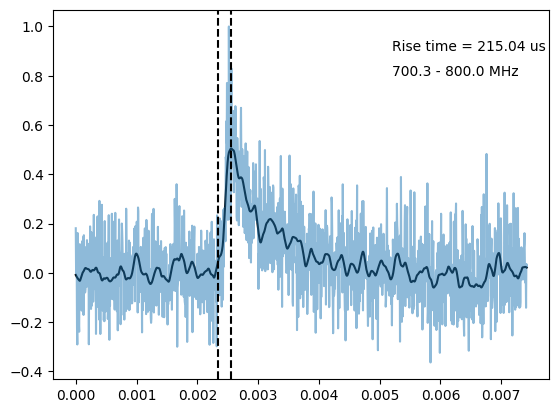

In [116]:
#### Calculate rise time with frequency #####

num_subbands = 4

fchans = int(wfall.shape[0]/num_subbands)

freqs = np.linspace(400,800,1024)

for i in range(num_subbands):
    
    start = i * fchans
    end = ((i+1) * fchans)-1
    
    ts = np.sum(wfall[start:end,], axis=0)
    ts = ts/np.max(ts)
    plot_time = np.arange(0,len(ts),1) * t_res

    
    smooth = lowess(ts, plot_time, frac=0.02)
    x, ts_smooth = smooth[..., 0], smooth[..., 1]
    
    plt.plot(x, ts_smooth, c='k')
    
    off_pulse = ts[0:int(len(ts)/5)]
    
    std_off = np.std(off_pulse)
    print(std_off)
    
    
    ##### Identifying where burst falls, or equal to std of off-pulse #####
    burst_fall = np.where(ts_smooth < np.max(ts_smooth)/10) 
    peak = np.argmax(ts_smooth)
    pts = abs(burst_fall[0] - peak)
    idx_fall = np.argmin(pts)
    fall_pt = burst_fall[0][idx_fall]
    
    rise_time = ((peak - fall_pt) * t_res ) * 1e6
    
    
    print("The rise time in channels {} to {} is {} us in frequency range {} - {} MHz".format(start, end, rise_time, freqs[start], freqs[end]))

    plt.plot(plot_time, ts, alpha=0.5)
    plt.axvline(peak * t_res, c = 'k', linestyle = '--')
    plt.axvline(fall_pt * t_res, c = 'k', linestyle = '--')
    plt.text( (0.7 * len(ts))*t_res, np.max(ts)*0.9, "Rise time = {} us".format(np.round(rise_time,2)))
    plt.text( (0.7 * len(ts))*t_res, np.max(ts)*0.8, "{} - {} MHz".format(np.round(freqs[start],1),np.round(freqs[end],1)))
    plt.show()
    